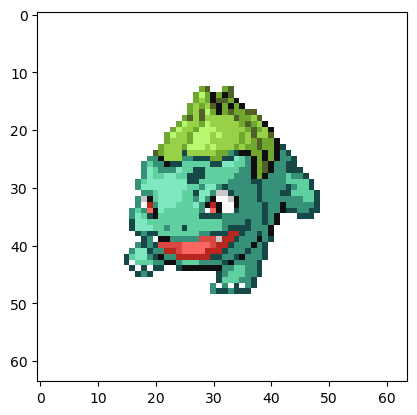

In [1]:
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
import numpy as np
from load_dataset import load_dataset, plot_image
from tqdm import tqdm
from random import randint
from matplotlib import pyplot as plt

torch.set_printoptions(sci_mode=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pimages = load_dataset().to(device)
pimages.shape # [3, 386, 3, 64, 64]

plot_image(pimages[0, 0, :, :, :])

In [2]:
#https://www.mdpi.com/2072-4292/11/9/1015/pdf
#@torch.compile
def ssim_loss(pred, target):
    mean_pred = torch.mean(pred, dim=(2, 3))
    mean_target = torch.mean(target, dim=(2, 3))

    var_pred = torch.var(pred, dim=(2, 3))
    var_target = torch.var(target, dim=(2, 3))

    cov = torch.mean(pred * target, dim=(2, 3)) - mean_pred * mean_target

    c1 = 0.01 ** 2
    c2 = 0.03 ** 2

    ssim = (2 * mean_pred * mean_target + c1) * (2 * cov + c2) 
    ssim /= (mean_pred ** 2 + mean_target ** 2 + c1) * (var_pred + var_target + c2)

    return (1 - ssim) / 2

In [3]:
Channels = 4

class PaletteDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.feat0 = nn.Parameter(torch.randn(1, 1, 16))
        self.linear = nn.Linear(16, Channels * 3)

        self.conv = nn.Conv2d(16, 4, kernel_size=1, bias=True)

        self.emb = nn.Conv2d(3, 16, kernel_size=1, bias=True)
        self.layer1 = nn.TransformerEncoderLayer(d_model=16, nhead=4, dim_feedforward=256, batch_first=True)
    
    def forward(self, x):
        x = self.emb(x)
        x = x.flatten(2, 3).permute(0, 2, 1)

        x = torch.cat([self.feat0.repeat(x.shape[0], 1, 1), x], dim=1)
        x = self.layer1(x)

        # x shape [batch, 64 * 64, 20]

        colors = x[:, 0, :].flatten(1)
        colors = self.linear(colors)
        
        image = x[:, 1:, :].permute(0, 2, 1).unflatten(2, (64, 64))
        image = self.conv(image)
        image = torch.softmax(image, dim=1)

        colors = colors.unflatten(1, (Channels, 3))
        colors = torch.sigmoid(colors) * 2 - 1
        
        return colors, image

  0%|          | 0/4001 [00:00<?, ?it/s]

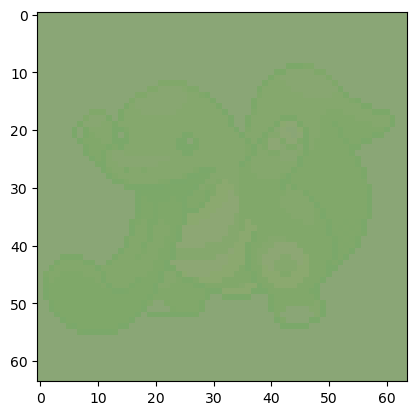

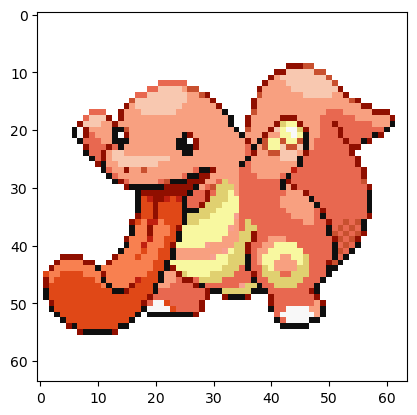

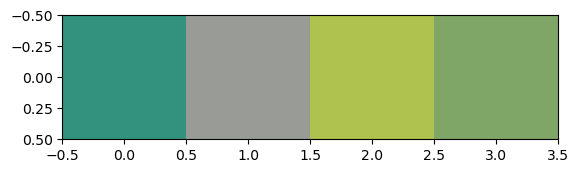

0.07522547:   2%|▏         | 100/4001 [02:53<1:45:23,  1.62s/it]

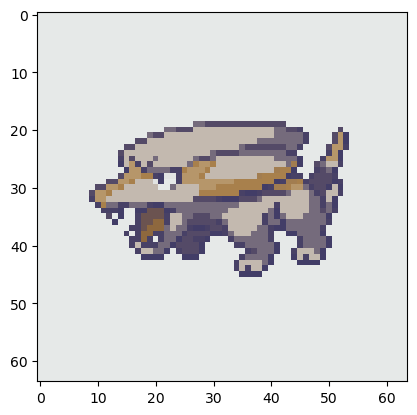

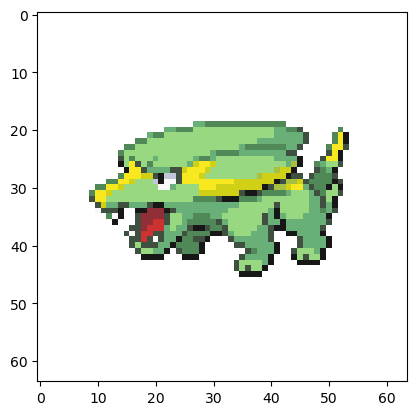

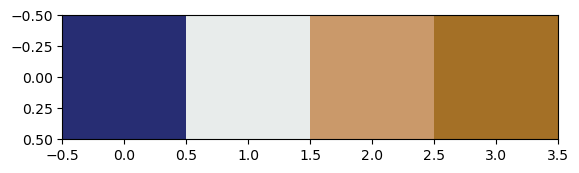

0.05619548:   5%|▍         | 200/4001 [05:42<1:54:40,  1.81s/it]

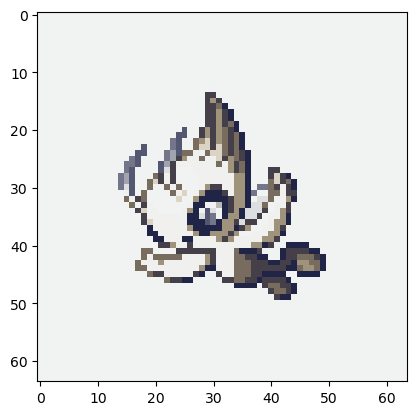

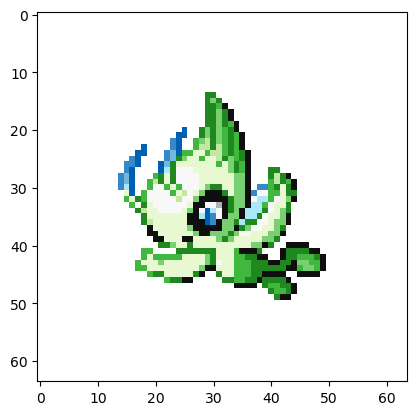

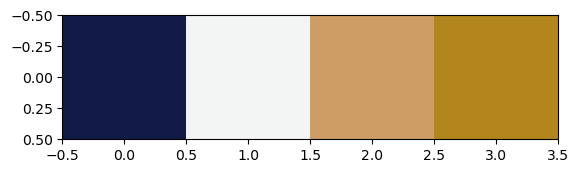

0.02653824:   7%|▋         | 300/4001 [08:33<1:50:39,  1.79s/it]

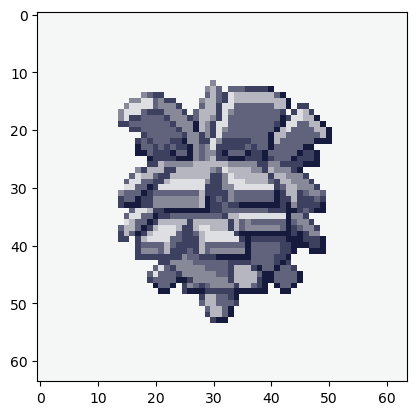

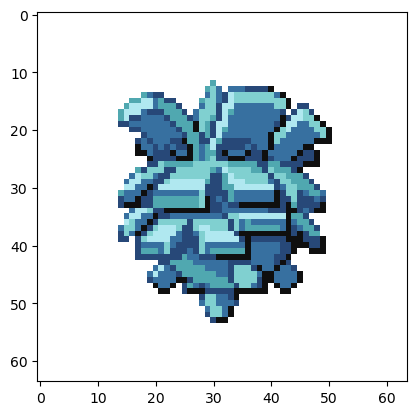

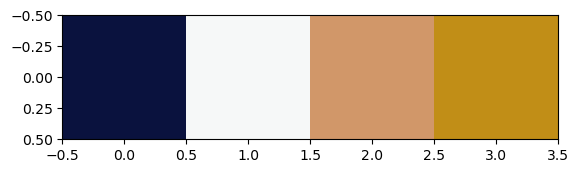

0.03615202:  10%|▉         | 400/4001 [11:23<1:39:42,  1.66s/it]

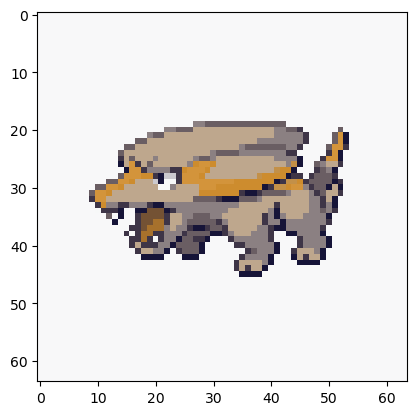

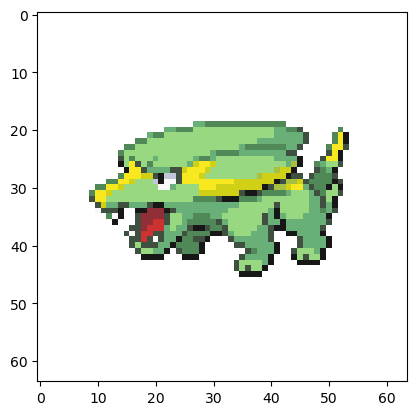

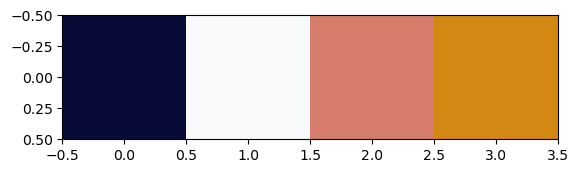

0.01349138:  12%|█▏        | 500/4001 [14:17<1:44:54,  1.80s/it]

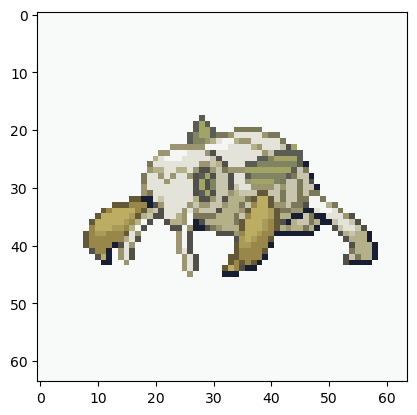

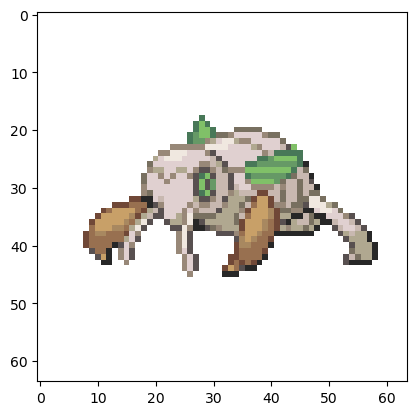

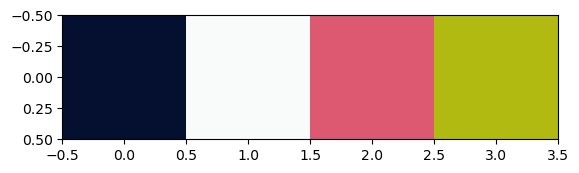

0.03486522:  15%|█▍        | 600/4001 [17:11<1:37:22,  1.72s/it]

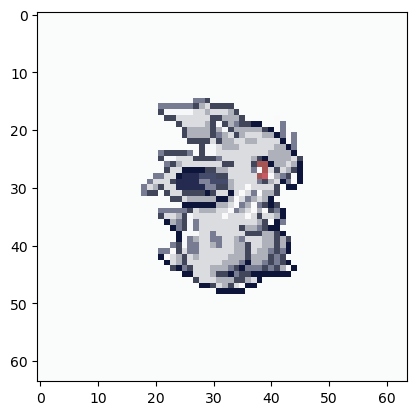

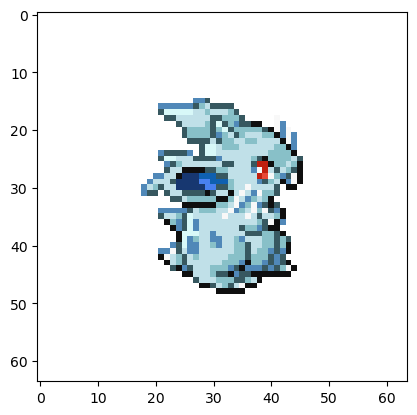

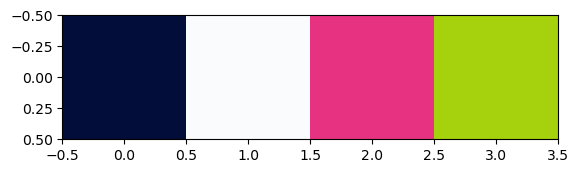

0.01032936:  17%|█▋        | 700/4001 [19:57<1:29:54,  1.63s/it]

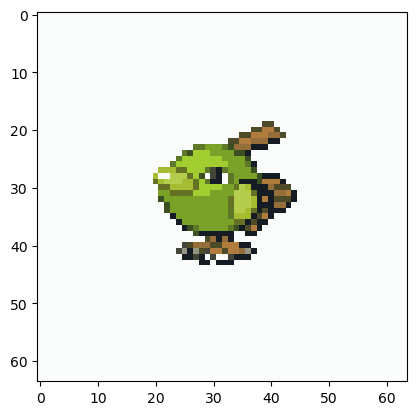

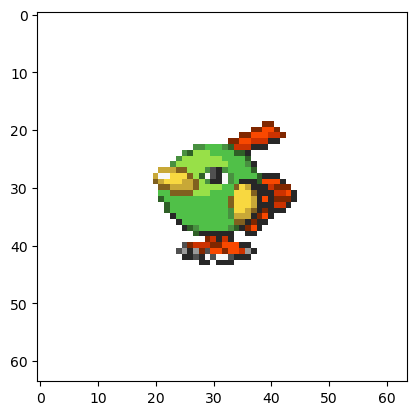

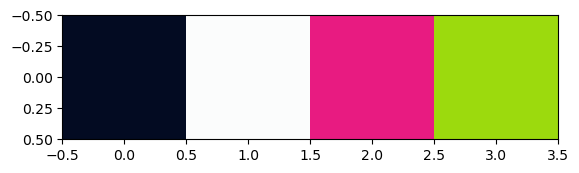

0.00925039:  20%|█▉        | 800/4001 [22:45<1:29:04,  1.67s/it]

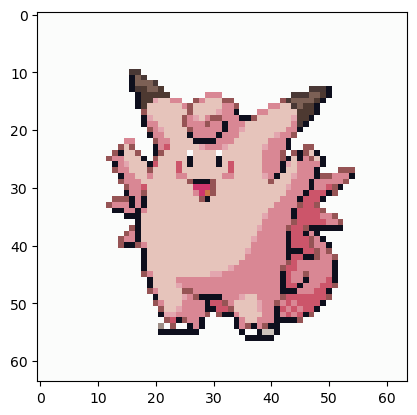

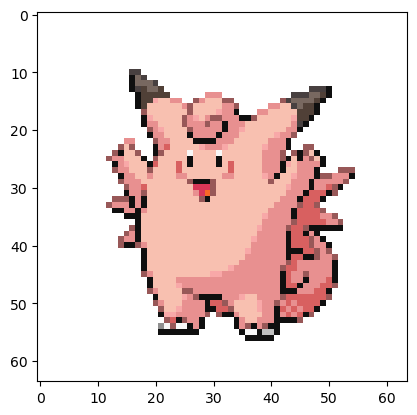

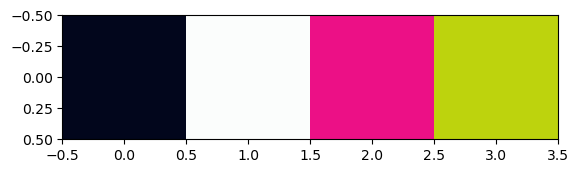

0.01793057:  22%|██▏       | 900/4001 [25:32<1:24:16,  1.63s/it]

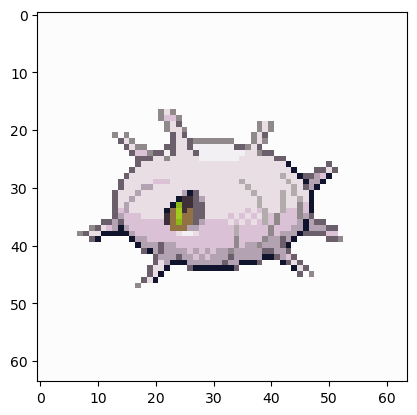

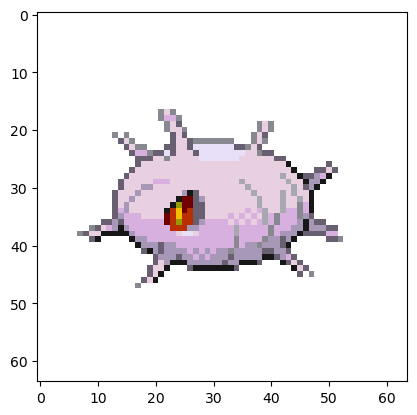

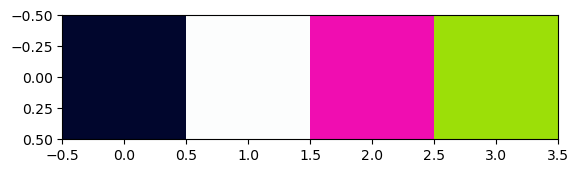

0.01602122:  25%|██▍       | 1000/4001 [28:22<1:23:31,  1.67s/it]

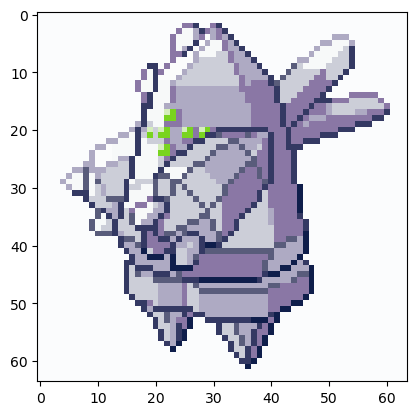

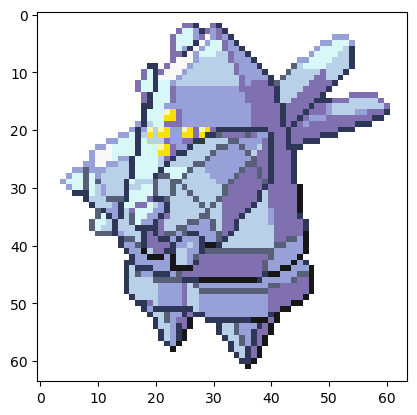

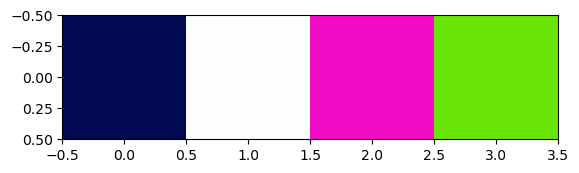

0.02265034:  27%|██▋       | 1100/4001 [31:12<1:23:07,  1.72s/it]

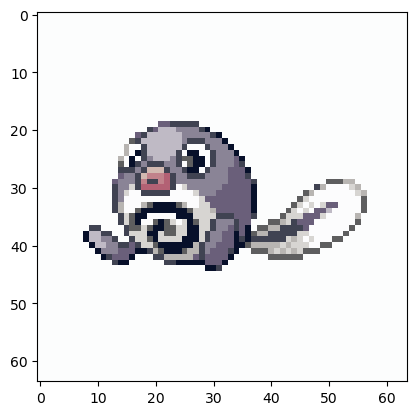

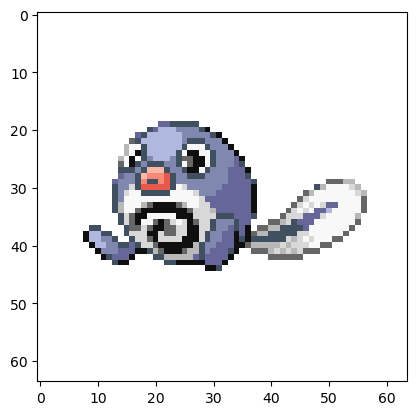

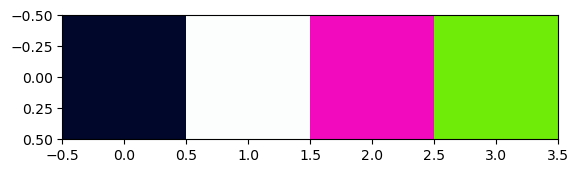

0.00587189:  30%|██▉       | 1200/4001 [33:59<1:16:53,  1.65s/it]

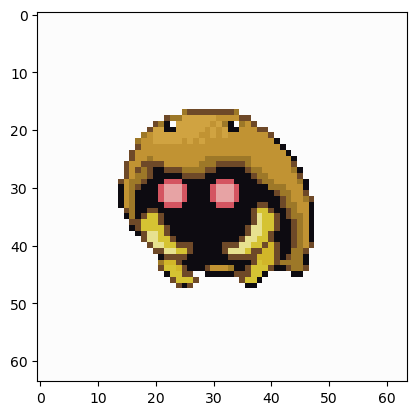

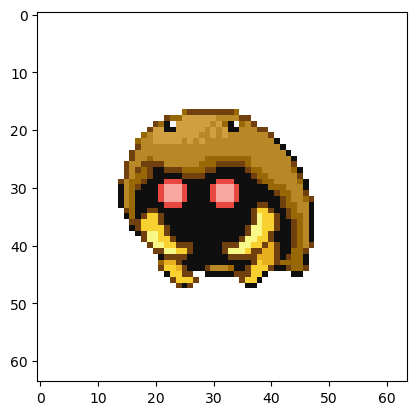

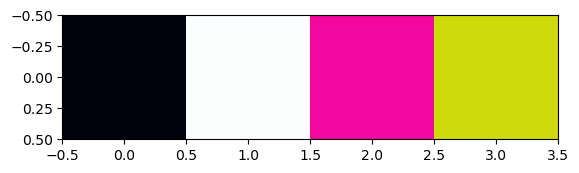

0.00752617:  32%|███▏      | 1300/4001 [36:49<1:15:52,  1.69s/it]

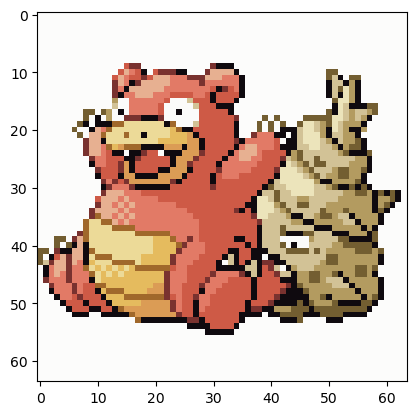

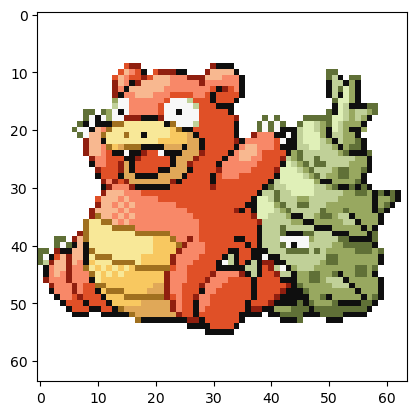

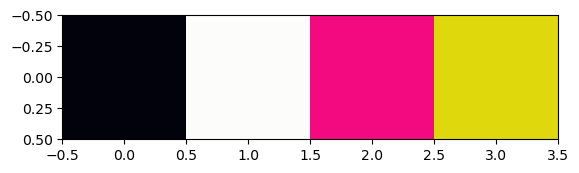

0.01840525:  35%|███▍      | 1400/4001 [39:40<1:10:54,  1.64s/it]

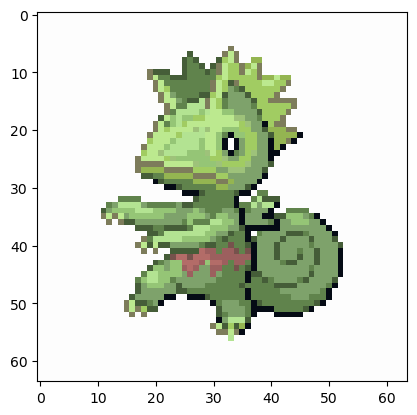

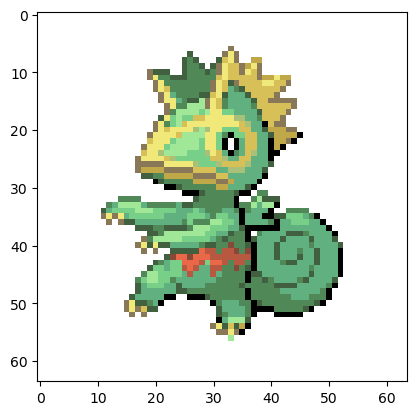

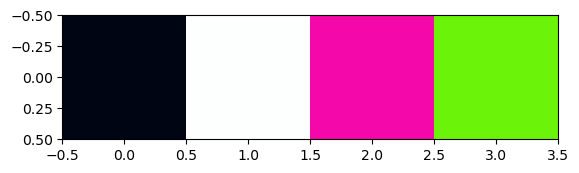

0.00534707:  37%|███▋      | 1500/4001 [42:34<1:09:07,  1.66s/it]

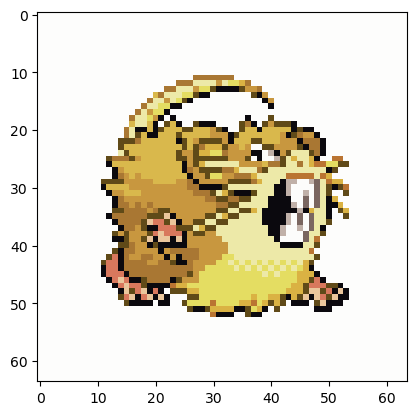

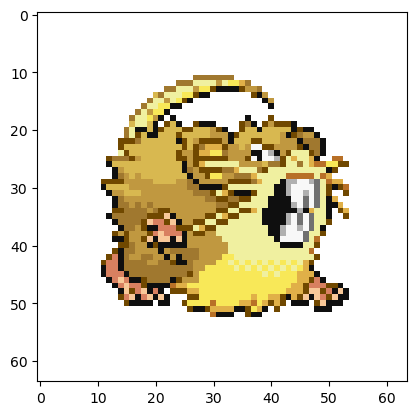

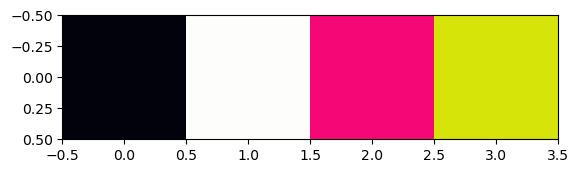

0.00497832:  40%|███▉      | 1600/4001 [45:24<1:07:47,  1.69s/it]

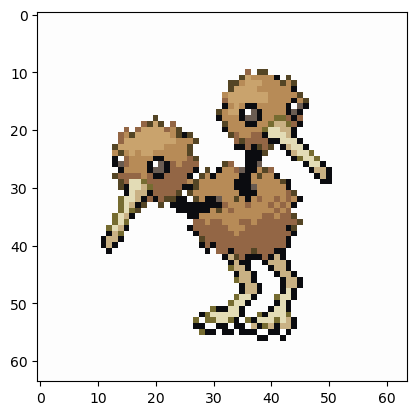

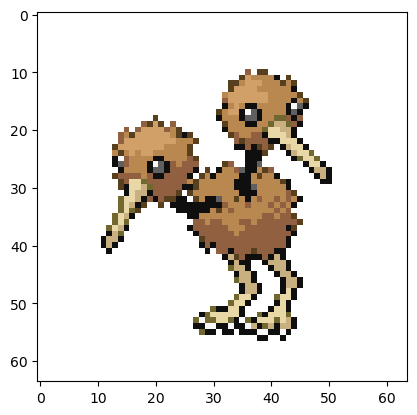

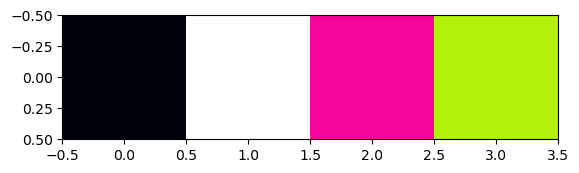

0.00715050:  42%|████▏     | 1700/4001 [48:19<1:08:12,  1.78s/it]

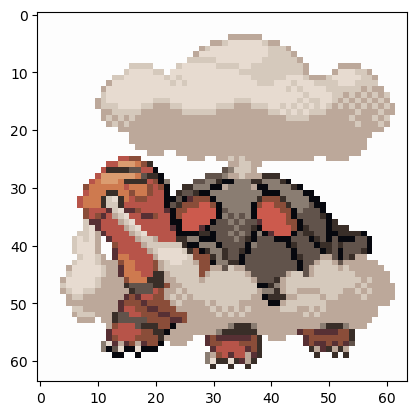

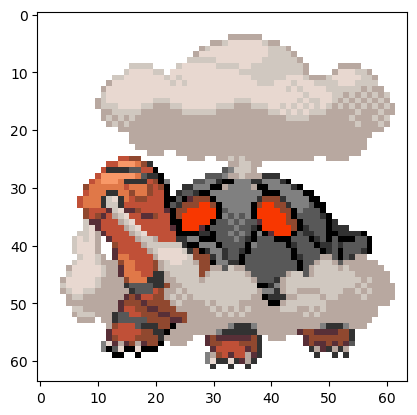

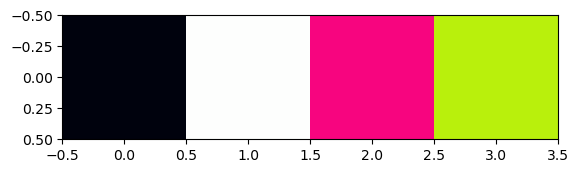

0.00627820:  43%|████▎     | 1706/4001 [48:31<1:05:17,  1.71s/it]


KeyboardInterrupt: 

In [4]:
bs = 16

model = PaletteDecoder().to(device)
loss_func = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

pbar = tqdm(range(4001))
def closure():
    optimizer.zero_grad()
    
    # Sample a batch of images
    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]

    # Shuffle the color channels
    color = torch.randperm(3)
    x0 = x0[:, color, :, :]

    # x0 dim = [bs, 3, 64, 64]

    colors, image = model(x0)
    image_rgb = ( image.flatten(2, 3).permute(0, 2, 1) @ colors ).permute(0, 2, 1).unflatten(2, (64, 64))

    loss = loss_func(image_rgb, x0)# + 0.5 * ssim_loss(image_rgb, x0).mean() + 0.05 * loss_func(colors @ colors.transpose(1, 2), torch.eye(4, device=device) * 2)
    
    pbar.set_description(f"%.8f" % loss, refresh=False)

    loss.backward()
    return loss


 
model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 100 == 0:
        with torch.no_grad():
            model.eval()
            
            source = randint(0, 2)
            batch = torch.randperm(385)[:1]
            x0 = pimages[source, batch]

            colors, image = model(x0)
            image_rgb = ( image.flatten(2, 3).permute(0, 2, 1) @ colors ).permute(0, 2, 1).unflatten(2, (64, 64))

            plot_image(image_rgb[0])
            plot_image(x0[0])

            plt.imshow(((colors[[0]] + 1) / 2).detach().cpu())
            plt.show()

            model.train()